In [38]:
import json, random, time
import numpy as np
from pprint import pprint
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
import requests
import urllib.request
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import pickle
import copy
import spacy
from spacy import displacy
from itertools import tee
import wikipedia
import pylcs
import string
np.set_printoptions(precision=4)

In [55]:
txt_dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/output_mine_all_schema.json", "r"))
print(len(txt_dataset))

7921


**Step 1: Question --> Identify keywords** NOUN, ADJ, NUM, PROPN, Capitalized words

**Step 2: Pos Facts --> Relevant Wiki pages** Hyperlink, wikipedia.search(pos_fact's title)

**Step 3: Wikipages --> html parsing --> paragraphs, images & their captions**

**Step 4: Choose paragraphs with high overlap with the question *without* giving away the core answer info** Punish overlapping with {Q} \\ {A &cup; G} 

In [3]:
nlp = spacy.load('en_core_web_sm')

In [4]:
def show_ents(doc): 
    if doc.ents: 
        for ent in doc.ents: 
            print(ent.text+' - ' +str(ent.start_char) +' - '+ str(ent.end_char) +' - '+ent.label_+ ' - '+str(spacy.explain(ent.label_))) 
    else: print('No named entities found.')

In [561]:
### NER does not give us what we want
ids = random.sample(range(7921), 5)
for i in ids:
    k = str(i)
    print(k)
    Q = txt_dataset[k]['Q']
    print('Q: ', Q)
    print('A: ', txt_dataset[k]['A'])
    for f in txt_dataset[k]['SupportingFacts']:
        print(f['fact'])
        print(f['url'])
    print("\nEntities:")
    doc = nlp(Q)
    show_ents(doc)
    if doc.ents: displacy.render(doc, style='ent', jupyter=True)
    for e in doc.ents:
        print(wikipedia.search(e.text))
    print(" ---------------------------------------------------------------------------- \n")

5114
Q:  How much higher did Take That & Party peak on the UK Albums Chart than Having a Party peaked on the Billboard Hot 100?
A:  Take That & Party peaked 15 spots spots higher on it's respective chart.
Released on 17 August 1992 on RCA Records, it reached number two on the UK Albums Chart and stayed in the UK Top 75 album chart for 73 weeks (one year, five months and one week). It was their only album not to reach number one until Wonderland peaked at number two in 2017.
https://en.wikipedia.org/wiki/Take_That_%26_Party
The song peaked at number four on Billboard 's Hot R&B Sides chart, and also charted at number 17 on the Billboard Hot 100 . "Having a Party", like its A-side, "Bring It On Home to Me", was written while Cooke was on tour for Henry Wynn.
https://en.wikipedia.org/wiki/Having_a_Party_(song)

Entities:
Take That & Party - 20 - 37 - ORG - Companies, agencies, institutions, etc.
UK - 50 - 52 - GPE - Countries, cities, states
Party - 80 - 85 - ORG - Companies, agencies, in

['Take That & Party', 'Take That', 'List of songs recorded by Take That', 'Take That discography', 'Wonderland (Take That album)', 'Greatest Hits (Take That album)', 'Could It Be Magic', 'Take That Presents: The Circus Live', 'III (Take That album)', 'Jason Orange']
['United Kingdom', 'Countries of the United Kingdom', '.uk', '2016 United Kingdom European Union membership referendum', 'List of political parties in the United Kingdom', 'UK garage', 'Postcodes in the United Kingdom', 'Sky UK', 'Prime Minister of the United Kingdom', 'UK Biobank']
['Party', 'Political party', 'Labour Party (UK)', 'Republican Party (United States)', 'Political parties in the United States', 'Social Democratic Party of Germany', 'One-party state', 'Democratic Party (United States)', 'Black Panther Party', 'National Party of Australia']
['100', '100 metres', '100%', 'Nasdaq-100', '$100', 'The 100', 'Time 100', 'Billboard Hot 100', "List of men's footballers with 100 or more international caps", '$100 hamburg

/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/spacy/displacy/__init__.py:189: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


 ---------------------------------------------------------------------------- 

515
Q:  What cardinal region of Hartford, Connecticut do the American soccer team Hartford City FC and University of Hartford's Hartford Hawks lie in?
A:  In West Hartford.
The Hartford Hawks are the NCAA Division I athletic teams of the University of Hartford, located in West Hartford, Connecticut.
https://en.wikipedia.org/wiki/Hartford_Hawks_softball
Hartford City FC is an American soccer team based in West Hartford, Connecticut. The team plays in the National Premier Soccer Leagues' Northeast Region, North Atlantic Conference.
https://en.wikipedia.org/wiki/Hartford_City_FC

Entities:
Hartford - 24 - 32 - GPE - Countries, cities, states
Connecticut - 34 - 45 - GPE - Countries, cities, states
American - 53 - 61 - NORP - Nationalities or religious or political groups
Hartford City FC - 74 - 90 - GPE - Countries, cities, states
University of Hartford's - 95 - 119 - ORG - Companies, agencies, institutions, et

['Hartford, Connecticut', 'The Hartford', 'Hartford Whalers', 'Travelers Championship', 'Dee Hartford', 'Greater Hartford', 'Asa Hartford', 'Hartford Athletic', 'Hartford Courant', 'Eden Hartford']
['Connecticut', 'The Haunting in Connecticut', 'Hartford, Connecticut', 'University of Connecticut', 'Connecticut River', 'List of municipalities in Connecticut', 'Bridgeport, Connecticut', 'Stamford, Connecticut', 'Sandy Hook Elementary School shooting', 'Connecticut Lakes']
['American', 'White Americans', 'American Express', 'African Americans', 'American Airlines', 'American Samoa', 'American football', 'American Idol', 'German Americans', 'American bison']
['Hartford City FC', 'Hartford City', 'Hartford, Connecticut', 'Hartford Athletic', 'National Premier Soccer League', 'Asa Hartford', 'Boston City FC', '2017 NPSL season', 'Al-Marzook Field at Alumni Stadium', 'New York City FC']
['University of Hartford', 'Hartford, Connecticut', 'West Hartford, Connecticut', 'Hartford Hawks', 'Univer

 ---------------------------------------------------------------------------- 

1192
Q:  What continents do the 31st parallel north and the 38th parallel north both cross?
A:  Asia and North America
The 38th parallel north is a circle of latitude that is 38 degrees north of the Earth's equatorial plane. It crosses Europe, the Mediterranean Sea, Asia, the Pacific Ocean, North America, and the Atlantic Ocean. The 38th parallel north formed the border between North and South Korea prior to the Korean War .
https://en.wikipedia.org/wiki/38th_parallel_north
In the United States, the 31st parallel defines part of the border between Mississippi and Louisiana, and part of the border between Alabama and Florida. The 31st parallel north is a circle of latitude that is 31 degrees north of the Earth's equatorial plane. It crosses Africa, Asia, the Pacific Ocean, North America and the Atlantic Ocean .
https://en.wikipedia.org/wiki/31st_parallel_north

Entities:
38th - 51 - 55 - ORDINAL - "first", "

['38th parallel north', '38th Street gang', '38th Street (Minneapolis)', '38th Infantry Division (United States)', 'Korean War', '38th Academy Awards', '38th Infantry Regiment (United States)', '38th Regiment', '38th Filmfare Awards', '38th SS-Grenadier-Division "Nibelungen"']
 ---------------------------------------------------------------------------- 



/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


44.5311007751938


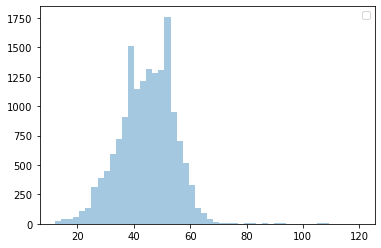

In [61]:
# Length distribution of pos facts (Whitespace tokenization)
fact_lengths = [len(f['fact'].split()) for k in txt_dataset for f in txt_dataset[k]['SupportingFacts']]
print(np.mean(fact_lengths))
sns.distplot(fact_lengths, kde=False)
plt.legend()

In [58]:
# spacy stopwords list covers more than nltk's
print(nlp.Defaults.stop_words) # spacy
print(stopwords.words('english')) #nltk

{'seeming', 'show', 'noone', 'over', 'should', 'whoever', 'beforehand', "'m", 'quite', 'put', 'either', 'call', 'hereby', 'elsewhere', 'thence', 'while', 'part', 'becoming', 'whereafter', 'neither', 'anywhere', 'nothing', 'some', 'both', 'four', 'empty', 'three', 'if', 'thereafter', 'already', 'do', '’ll', 'became', 'am', 'namely', 'ca', 'get', 'becomes', 'whither', 'could', 'therein', 'twenty', 'we', 'amongst', 'whence', 'otherwise', '’d', 'further', 'sixty', 'within', 'meanwhile', 'though', 'whereby', 'why', 'than', 'due', 'thus', 'with', 'were', 'move', 'only', 'therefore', 'being', 'an', 'per', 'wherever', 'any', 'who', 'mine', 'n’t', 'onto', 'several', 'cannot', "'ve", 'again', 'enough', 'once', 'or', 'thereupon', 'forty', 'every', 'alone', 'own', "'ll", 'he', '’s', 'often', 'whether', 'might', 'however', 'by', 'back', 'what', 'nobody', 'hereafter', 'many', 'this', 'almost', 'afterwards', 'become', 'say', 'top', 'will', 'not', 'they', 'two', 'everywhere', 'into', 'can', 'ten', 'mu

In [756]:
doc = nlp("The ancient Egyptians had an elaborate set of funerary practices that they believed were necessary to ensure their immortality after death. These rituals included mummifying the body, casting magic spells, and burials with specific grave goods thought to be needed in the afterlife.")
for s in doc.sents:
    print("sentence: -------------", len(s))
    for t in s:
        print(t.is_sent_start, t.i - s.start)

sentence: ------------- 22
True 0
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
False 18
False 19
False 20
False 21
sentence: ------------- 25
True 0
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
False 18
False 19
False 20
False 21
False 22
False 23
False 24


In [59]:
### num_sents, num_dots statistics for positive facts
num_sents = []
num_dots = []

for k in txt_dataset:
    for f in txt_dataset[k]['SupportingFacts']:
        doc = nlp(f['fact'])
        num_sents.append(len(list(doc.sents)))
        num_dots.append(f['fact'].count('.'))
        
print(np.mean(num_sents), np.std(num_sents))
print(np.mean(num_dots), np.std(num_dots))

2.2571162790697676 0.9147201345021733
2.457612403100775 1.2233966714275941


### Mridu sent updated 7921samples, fixed "missing pos facts"

In [60]:
new_txt_data = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/output_mine_all_schema.json", "r"))
print(len(new_txt_data))
print(Counter([len(new_txt_data[k]['SupportingFacts']) for k in new_txt_data]))
'''
temp = {}
count = 0
for i in new_txt_data:
    temp[count] = copy.deepcopy(i)
    temp[count]['Q'] = temp[count]['Question']
    temp[count]['A'] = temp[count]['Answer']
    del temp[count]['Question']
    del temp[count]['Answer']
    count += 1
json.dump(temp, open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/output_mine_all_schema.json", "w"), indent=4)
'''

7921
Counter({2: 7657, 3: 245, 4: 19})


'\ntemp = {}\ncount = 0\nfor i in new_txt_data:\n    temp[count] = copy.deepcopy(i)\n    temp[count][\'Q\'] = temp[count][\'Question\']\n    temp[count][\'A\'] = temp[count][\'Answer\']\n    del temp[count][\'Question\']\n    del temp[count][\'Answer\']\n    count += 1\njson.dump(temp, open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/output_mine_all_schema.json", "w"), indent=4)\n'

In [ ]:
def sample2keywords(k):
    Q = new_txt_data[str(k)]['Q']
    doc = nlp(Q)
    keywords = set([t.text for s in doc.sents for t in s if t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper())])

    keywords = keywords - PUNCTUATIONS        

    A = new_txt_data[str(k)]['A']
    doc = nlp(A)
    answerwords = set([t.text for t in doc if t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper())])
    answerwords = answerwords - PUNCTUATIONS

    goldfactwords = set()
    titlewords = set()
    Q_A_words = keywords.union(answerwords)
    for f in new_txt_data[str(k)]['SupportingFacts']:
        doc = nlp(f['fact'])
        goldfactwords = goldfactwords.union(set([t.text for t in doc if t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper())]) - Q_A_words)
        fact_title_raw = ' '.join(urllib.parse.unquote(f['url']).split('/')[-1].split('_'))
        fact_title = pattern.sub('', fact_title_raw)
        titlewords = titlewords.union(fact_title.split())
    goldfactwords = goldfactwords - PUNCTUATIONS 
    titlewords = titlewords - PUNCTUATIONS

    word_lists = [titlewords, keywords, goldfactwords, answerwords]
    return word_lists

In [ ]:
def add_html_row_vis_ori_dataset(k, word_lists, colors = ["(223, 255, 238)", "(193, 239, 253)", "(253, 252, 152)", "(255, 214, 222)"]):
    html = ""
    html += '<tr><td>{}.</td><td>Q: {}<br>'.format(k, highlight_words(word_lists, colors, new_txt_data[str(k)]['Q']))
    for f in new_txt_data[str(k)]['SupportingFacts']:
        html += '<br><br>&nbsp;&nbsp;{}'.format(highlight_words(word_lists, colors, f['fact']))
        html += '<a href="{}"> link</a>'.format(f['url'])
    html += '<br><br>A: {}<br>'.format(highlight_words(word_lists, colors, new_txt_data[str(k)]['A']))
    html += '</td><td>'
    
    for f in new_txt_data[str(k)]['DistractorFacts']:            
            html += highlight_words(word_lists, colors, f['fact'])
            html += '<a href="{}"> {}</a><br><br>'.format(f['url'], f['title'])
    html += '</td></tr>'
    html += '<tr><td colspan=3><hr></td></tr>'
    return html

In [ ]:
sampled_indx = random.sample(range(7921), 25)

html = "<html><body>"
html += '<table border="0" style="table-layout: fixed; width: 100%; word-break:break-word">'
html += '<tr bgcolor=gray><td width=5%>Index</td><td width=35%>Q & Pos Facts</td><td width=60%>Neg Facts</td></tr>'
count = 0
for k in sampled_indx:
    count += 1
    word_lists = sample2keywords(k)[:2]
    html += add_html_row_vis_ori_dataset(k, word_lists)
    o = open('txt_dataset_vis.html', 'wt')

    o.write(html)
    o.close()
html += '</table></body></html>'
o = open('txt_dataset_vis.html', 'wt')

o.write(html)
o.close()

### txt dataset collection done

In [75]:
new_txt_data = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_0728.json", "r"))
print(len(new_txt_data))
print(Counter([len(new_txt_data[k]['SupportingFacts']) for k in new_txt_data]))
'''
temp = {}
count = 0
for i in new_txt_data:
    temp[count] = copy.deepcopy(i)
    temp[count]['Q'] = temp[count]['Question']
    temp[count]['A'] = temp[count]['Answer']
    del temp[count]['Question']
    del temp[count]['Answer']
    del temp[count]['BucketId']
    del temp[count]['GeneratedBy']
    del temp[count]['ValidatedBy']
    del temp[count]['SupportingImageIds']
    del temp[count]['DistractorImageIds']
    count += 1
json.dump(temp, open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_0728.json", "w"), indent=4)
print(count)
'''

25351
Counter({2: 24398, 3: 900, 4: 47, 1: 5, 5: 1})


'\ntemp = {}\ncount = 0\nfor i in new_txt_data:\n    temp[count] = copy.deepcopy(i)\n    temp[count][\'Q\'] = temp[count][\'Question\']\n    temp[count][\'A\'] = temp[count][\'Answer\']\n    del temp[count][\'Question\']\n    del temp[count][\'Answer\']\n    del temp[count][\'BucketId\']\n    del temp[count][\'GeneratedBy\']\n    del temp[count][\'ValidatedBy\']\n    del temp[count][\'SupportingImageIds\']\n    del temp[count][\'DistractorImageIds\']\n    count += 1\njson.dump(temp, open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_0728.json", "w"), indent=4)\nprint(count)\n'

In [76]:
txt_dataset_0725 = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_0725.json", "r"))
print(len(txt_dataset_0725))
guids_all = [new_txt_data[k]['Guid'] for k in new_txt_data]
guids_0725 = [txt_dataset_0725[k]['Guid'] for k in txt_dataset_0725]
print(len(guids_all), len(guids_0725))
print(len([k for k in guids_0725 if k in guids_all]))

7921
25351 7921
7921


In [79]:
## remove 0725 data, mine distractors for the rest
print(25351 - 7921)
temp = copy.deepcopy(new_txt_data)
for k in list(temp.keys()):
    if temp[k]['Guid'] in guids_0725:
        del temp[k]
print(len(temp))
json.dump(temp, open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_0728_16k_new.json", "w"), indent=4)

17430
17430


In [85]:
print(Counter([len(new_txt_data[k]['DistractorFacts']) for k in temp]))

Counter({5: 3604, 4: 3344, 6: 2577, 7: 1788, 8: 1359, 9: 1013, 10: 792, 11: 580, 12: 544, 13: 380, 14: 276, 15: 246, 16: 190, 17: 148, 18: 124, 3: 101, 19: 99, 22: 50, 20: 47, 21: 40, 23: 36, 24: 21, 26: 19, 25: 17, 27: 8, 29: 8, 2: 5, 28: 4, 33: 4, 34: 2, 41: 2, 32: 2})


In [88]:
print(list(temp.keys()))

['0', '1', '6', '7', '8', '9', '13', '14', '16', '17', '18', '20', '22', '23', '24', '26', '27', '28', '29', '30', '31', '32', '33', '34', '36', '37', '38', '39', '40', '41', '43', '44', '46', '47', '49', '51', '52', '55', '56', '57', '58', '59', '60', '61', '62', '63', '65', '66', '68', '69', '70', '72', '74', '75', '76', '77', '78', '80', '81', '83', '84', '85', '87', '88', '91', '92', '93', '95', '96', '97', '98', '99', '100', '101', '102', '103', '107', '108', '109', '110', '111', '112', '113', '114', '116', '118', '119', '121', '122', '123', '125', '127', '128', '129', '131', '133', '134', '135', '136', '137', '138', '139', '140', '141', '144', '145', '146', '148', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '161', '162', '164', '166', '168', '169', '170', '172', '173', '174', '175', '176', '179', '180', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204',